# Part 3: SGD

In [1]:
import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from useful_functions import unison_shuffled_copies, get_train_test_datasets, gradient_descent

### Question 1: Implement stochastic gradient and compare its performance with that of your gradient descent implementation from Part 1 on the same problem and dataset. What happens when both methods are run using the same stepsize? Do your observations confirm what has been discussed during the lecture?

**Stochastic Gradient Descent (SGD)** will perform the gradient computing for a single sample in the dataset. Therefore, one update of the weights is performed for every training sample, which makes it more efficient than classic GD when having huge datasets and correlated data sample. The $i_k$ are drawn at random uniformely in $\{1,\dots,n\}$.

$$
\forall i_k \in\{1, \ldots, n\}:  x^{(k+1)} = x^{(k)}-\tau \nabla L_{x}\left(x^{(k)}, A^{(ik)}, Y^{(ik)}\right)
$$

with $L$ the function to minimize.

In [3]:
dataset = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)
A = dataset['data']
Y = dataset['target']

TRAINING_RATIO = 0.75

A_shuffled, Y_shuffled = unison_shuffled_copies(A, Y)
A_train, Y_train, A_test, Y_test = get_train_test_datasets(A_shuffled, Y_shuffled,TRAINING_RATIO)

In [12]:
#SGD implementation 
n_epochs = 50
step_size = 1e-5
iter_per_epoch = A_train.shape[0]

D = A_train.shape[1] #dimension of x 
x = np.random.rand(D) # random initialization

loss_function_array_sgd = []
loss_function_array_sgd_iteration = []
iteration = []
epochs = []

for epoch in range(n_epochs):
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_array_sgd.append(loss_function_train)

    for i in range(iter_per_epoch):
        iteration.append(iter_per_epoch*epoch+i)
        loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
        loss_function_array_sgd_iteration.append(loss_function_train)
        random_index = np.random.randint(iter_per_epoch)
        Ai = A_train[random_index:random_index+1]
        Yi = Y_train[random_index:random_index+1]
        gradients = 2*Ai.T.dot(Ai.dot(x) - Yi)
        x = x - step_size * gradients

In [5]:
#GD implementation 
n_epochs = 50
step_size = 1e-5

x = np.random.rand(D) # random initialization

loss_function_array = []
epochs = []

for epoch in range(n_epochs):
    #here only one iteration per epoch
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_array.append(loss_function_train)
    gradients = 2*A_train.T.dot(np.dot(A_train,x)-Y_train)
    x = x - step_size * gradients

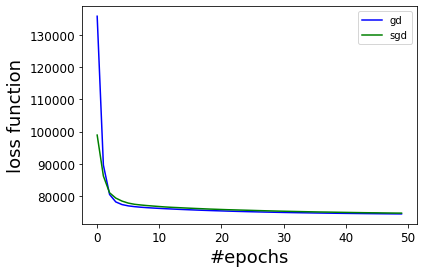

In [13]:
plt.plot(epochs, loss_function_array, color = 'b', label = 'gd')
plt.plot(epochs, loss_function_array_sgd, color='g', label = 'sgd')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

Per each single iteration, the GD is more efficient than SGD but that is because it relies on more data per iteration (n) than sgd (only one). The right way of comparing them is by number of epochs, and in that sense SGD is genearally more efficient, especially if the data is quite redundant. Here, they bring quite similar results, probably because the linear model underfits the data. 
NB: as we reprensent SGD by epochs, and not by iteration, the stochaticity of the SDG isn't that (it decreases in expectancy). See next plot for the small bump that characterize stochasticity.

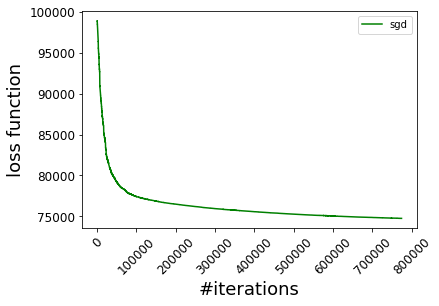

In [15]:
plt.plot(iteration, loss_function_array_sgd_iteration, color='g', label = 'sgd')
plt.xlabel("#iterations", rotation=0, fontsize=18)
plt.xticks(rotation=45)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

### Question 2: Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.


**Batch Gradient Descent (BGD)** will perform the gradient computing for a batch of data, instead of the whole dataset or just unique samples. $i_k$ is the set of indices drawn at random.

$$
    \mathbf{x}_{k+1} = \mathbf{x}_k - \frac{\alpha_k}{|S_k|} \sum_{i \in S_k} \nabla f_i(\mathbf{x}_k)
$$
where $S_k$ is a set of indices drawn uniformly in $\{1,\dots,n\}$. For this lab, the samples will be drawn without replacement, so that $|S_k|=n$ results in a full gradient step, while $|S_k|=1$ corresponds to a basic stochastic gradient step.

In [16]:
#Mini batch implementation 
n_epochs = 50
step_size = 1e-5
minibatch_size = 10
iter_per_epoch = round(A_train.shape[0]/minibatch_size) #change iter per epoch

x = np.random.rand(D) # random initialization

loss_function_array_mgd = []
epochs = []

for epoch in range(n_epochs):
    epochs.append(epoch)
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_array_mgd.append(loss_function_train)

    for i in range(iter_per_epoch):
        shuffled_indices = np.random.permutation(A_train.shape[0])
        A_train_shuffled = A_train[shuffled_indices]
        Y_train_shuffled = Y_train[shuffled_indices]
        random_index = np.random.randint(A_train.shape[0]-minibatch_size)
        Ai = A_train_shuffled[random_index:random_index+minibatch_size]
        Yi = Y_train_shuffled[random_index:random_index+minibatch_size]
        gradients = 2*Ai.T.dot(Ai.dot(x) - Yi)
        x = x - step_size * gradients

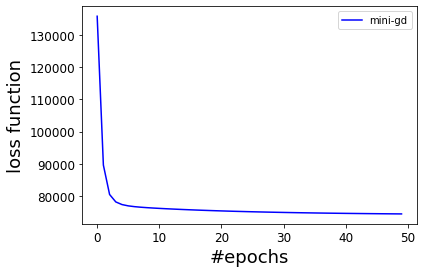

In [17]:
plt.plot(epochs, loss_function_array, color = 'b', label = 'mini-gd')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

Having a batch size too small, led the method to be similar to SGD (decrease only in expectancy), whereas having a high value of batch size led to a behaviour similar to GD. As we don't have too much data, we can rely on GD and choose a high batch size. On the contrary, SGD incurs much more latency because of the many more iterations. But apart from inference time, batch size doesn't seem to play a significant role with our data. The previous plot corresponds to a batch size of 10, but we obtain closed results with very different batch sizes.

### Question 3: Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them.


In this section we implement gradient descent with momentum. 
$$
\begin{array}{l}
v^{(k+1)} = \beta v^{(k)}+\tau \nabla_{x} L\left(x^{(k)}\right) \\
x^{(k+1)} = x^{(k)} - v^{(k+1)}
\end{array}
$$

with $\beta > 0$ the momentum parameter and $v^{(0)} = 0$. 

In [23]:
#SGD implementation with momentum
n_epochs = 50
step_size = 1e-5
beta = 3e-5
iter_per_epoch = A_train.shape[0]

D = A_train.shape[1] #dimension of x 
x = np.random.rand(D) # random initialization
V = np.zeros(D) #initialization at 0 

loss_function_array_sgd_momentum = []
loss_function_array_sgd_momentum_iteration = []
iteration = []
epochs = []

for epoch in range(n_epochs):
    epochs.append(epoch)
    
    loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
    loss_function_array_sgd_momentum.append(loss_function_train)

    for i in range(iter_per_epoch):
        iteration.append(iter_per_epoch*epoch+i)
        loss_function_train = np.linalg.norm(np.dot(A_train,x)-Y_train)**2
        loss_function_array_sgd_momentum_iteration.append(loss_function_train)
        random_index = np.random.randint(iter_per_epoch)
        Ai = A_train[random_index:random_index+1]
        Yi = Y_train[random_index:random_index+1]
        gradients = 2*Ai.T.dot(Ai.dot(x) - Yi)
        V = beta * V + step_size * gradients
        x = x - V

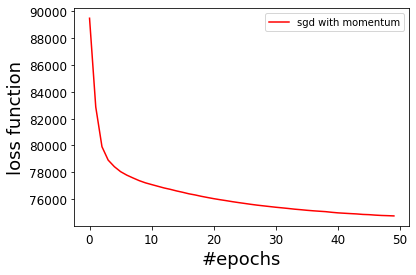

In [25]:
plt.plot(epochs, loss_function_array_sgd_momentum, color='r', label = 'sgd with momentum')
plt.xlabel("#epochs", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

Interestingly, the momentum method allows to reach reach a better accuracy as the loss function seems to converges towars a value smaller than the one with SGD. As the optimization problem is the same, and is convex, I don't have explanation for why the momentum leads better results here.
Nevertheless the rate of a convergence seems to be a little bit slower.